# **In-Class Assignment: Feature Engineering Part 2: Word Embeddings**
## *IS 5150*
## Name: Key

In this notebook we will cover several models used for feature engineering word embeddings for text, so that we can better represent word meaning in our texts.

In this example we will use the *King James Bible* from the gutenberg corpus as a large sample that we can use to train a word-embedding model. Training word-embedding models is pretty computationally expesnive, and time-consuming. So, I'm going to show you how to access a GPU instance from google colab and you will run this notebook outside of class :)

While I want you to understand how word-embedding models can be trained, we'll also play around with some pretrained models as well, which oftentimes can work quite well out of the box and can save time and effort. We'll apply those pretrained models to our toy corpus from P1 and then extend it to our document clustering.

## **1) Getting Set up**

Let's get started with reading in our required libraries and packages:

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
from nltk.corpus import gutenberg

from string import punctuation
from urllib import request
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import re

wpt = nltk.WordPunctTokenizer()                                               # assign wordpunctokenizer to wpt
stop_words = nltk.corpus.stopwords.words('english')                           # bring in stopwords from nltk

In [ ]:
url = "https://gutenberg.org/files/10/10-h/10-h.htm"
response = request.urlopen(url)

raw = response.read().decode('utf-8-sig')
raw
print(raw.find("1:1"), ":", raw.rfind("END OF THE PROJECT GUTENBERG"))

10282 : 4634877


In [ ]:
raw = raw[10282:4634877]

> #### **A) Define Normalize Document Function**



In [ ]:
def normalize_document(doc):
    soup = BeautifulSoup(doc, 'html.parser')
    [s.extract() for s in soup(['iframe', 'script'])]
    doc = soup.get_text()
    doc = re.sub(r'[^a-zA-Z\.\s]', '', doc)
    doc = doc.lower()
    doc = doc.strip()
    tokens = wpt.tokenize(doc)                                                   # tokenize document
    filtered_tokens = [token for token in tokens if token not in stop_words]     # filter out stopwords from document
    doc = ' '.join(filtered_tokens)                                              # re-create doucment from filtered tokens
    return doc

> #### **B) Apply Normalization Function, tokenize the sentences, then remove punctation**

In [ ]:
norm_bible = normalize_document(raw)

In [ ]:
punkt_st = nltk.tokenize.PunktSentenceTokenizer()
norm_sents = punkt_st.tokenize(norm_bible)
def remove_punc(string):
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    for ele in string:  
        if ele in punc:  
            string = string.replace(ele, " ") 
    return string
 
norm_sents = [remove_punc(i) for i in norm_sents]
norm_sents[0:5]

['beginning god created heaven earth  ',
 'earth without form void darkness upon face deep  ',
 'spirit god moved upon face waters  ',
 'god said let light light  ',
 'god saw light good god divided light darkness  ']

## **2) Training a Word2Vec Model for Word Embeddings**

### Continuous Bag of Words (CBOW) Model 

Let's first try implementing this method from scratch to understand how the model works; it involves five primary steps:
1. Building the corpus vocabulary
2. Building a CBOW (context, target) generator
3. Building the CBOW model archicture
4. Training the model
5. Getting the word embeddings!


> #### **A) Building corpus vocab**
> The first step in this process is separating out the text into the vocabulary, which consists of all the unique words in the text. We will need to bring in some new libraries that are often used in NLP and machine learning, including`tensorflow`.

In [ ]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence 

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = text.Tokenizer() 
tokenizer.fit_on_texts(norm_sents)                                                        # tokenize norm_bible text
word2id = tokenizer.word_index                                                            # store word index numbers

In [ ]:
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}                                               # create dictionary of words with their index numbers

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_sents]      # create list of lists of word sequences for each sentence in norm_bible, represented by word index number

**Let's take a step back and see what each of these variables contain...**

In [ ]:
vocab_size = len(word2id)
embed_size = 100
window_size = 2                                                                           # context window size, how many words surrounding target word are taken into account

print('Vocab Size:', vocab_size)
print('\nVocab Sample:', list(word2id.items())[:10])

Vocab Size: 12568

Vocab Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('said', 7), ('ye', 8), ('thee', 9), ('upon', 10)]


**What does it mean to have a window size of 2?**

> #### **B) Building CBOW (Context, Target) Generator**

In [ ]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2                                                                    # context is 2 words to either side of the target word
    for words in corpus:                                                                              # for each word in corpus...
        sentence_length = len(words)                                                                  # set the sentence length to the length of words
        for index, word in enumerate(words):                                                          # assign numeric value for each word, use as index
            context_words = []                                                                        # create list for context_words
            label_word = []                                                                           # create list of label words 
            start = index - window_size                                                               # set the start to be 2 left of the index (window)
            end = index + window_size + 1                                                             # set the end to be the 3 right of the index

            context_words.append([words[i]                                                            # fill in the context words for each word in the corpus between start, end
                                 for i in range(start, end)                                                   
                                 if 0 <= i < sentence_length
                                 and i != index])
            label_word.append(word)                                                                   # add word label to each word
            
            x = pad_sequences(context_words, maxlen = context_length)                                 # save context words to x
            y = np_utils.to_categorical(label_word, vocab_size)                                       # save associated target word to y
            yield(x, y)

**Now let's apply our context word pair generator to a sample of our first 10 words from our corpus to see a) what it does and b) that it worked.**

In [ ]:
i = 0
for x, y in generate_context_word_pairs(corpus = wids, window_size=window_size, vocab_size=vocab_size):                   # set corpus to word sequences from norm_bible
    if 0 not in x[0]:                                                                                                     # window size is 2, vocab_size is vocab_size
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])             # start at word 0, end at word 9
        if i == 9:
            break
        i += 1

Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light
Context (X): ['saw', 'light', 'god', 'divided'] -> Target (Y): good


**Let's check in a make sure we understand the components here: What is the window size and how do you know? What is the relationship between the context words (X) and the target word (Y)?**

> #### **C) Build the CBOW Architecture**

This step is a brief venture into some deep learning to utilize Word2Vec to training word embeddings...The CBoW archictecture can be broken down into:

1. An embedding layer (where our context words are pass in as inputs) → word weights/embeddings are randomly initialized
2. A lambda layer → average the word embeddings
3. Dense softmax layer → predicts the target word

We match the predicted target against the actual target word and compute the error/loss using a metric called `categorical_crossentropy` then perform back propagation with each epoch (full run through) of our model...

We will then take the learned weights from this word prediction task and use them as our word embeddings!


In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

In [ ]:
cbow = Sequential()
cbow.add(Embedding(input_dim = vocab_size, output_dim = embed_size, input_length = window_size*2)) #what are these inputs?
cbow.add(Lambda(lambda x: K.mean(x, axis = 1), output_shape = (embed_size,)))
cbow.add(Dense(vocab_size, activation = 'softmax'))
cbow.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop')

print(cbow.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            1256800   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12568)             1269368   
                                                                 
Total params: 2,526,168
Trainable params: 2,526,168
Non-trainable params: 0
_________________________________________________________________
None


**Examining the output shape, do any of these values look familiar? Let's talk them through.**

Number of parameters for embedding is our vocab*length of the embedding (100 dimensional vector generated for 12,568 words) = 1256800 parameters

Dense embeddings is our 1256800 + our vocab size = 1269368 parameters

> #### **D) Train the model (for a few epochs)**
> So here's the step I'll have you guys do outside of class, because this is going to take some time to train. Click the *Runtime* menu above, and select the option to *Change runtime type* and select the *GPU* option. Once you do that, you'll need to rerun the above cells (it will start a new session) and then go ahead and kick off training. This might take like 2 hours or so...so go watch a movie or work on something else and leave this running. The joys of training complex models!

In [ ]:
%%time 

for epoch in range(1,4):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus = wids, window_size=window_size, vocab_size=vocab_size):
        i +=1
        loss += cbow.train_on_batch(x, y)
        if i % 1000 == 0:
            print('Processed {} (context, word) pairs'.format(i))
    print('Epoch:', epoch, '\tloss:', loss)
    print()

**How many epochs did you try? How long did it take to train your word embeddings model (approximately)?**

> #### **D) Get the word embeddings!**
> First we need to grab the weights for each word, this is a stored parameter from `cbow`. We'll put these in a dataframe with the word labels.

In [ ]:
weights = cbow.get_weights()[0]                                                       # assign the learned weights to weights
weights = weights[1:]                                                                 # skip first token (start token)
print(weights.shape)                                                                  

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()                        # show weights with an index of their associated word in a dataframe

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
unto,-2.225993,1.836853,-2.139887,2.332495,2.521954,2.330496,1.994589,-2.196422,2.202455,-3.290952,...,-2.140275,2.486768,-2.024182,-2.103471,2.749426,-2.713324,-2.357984,-1.937865,-2.598071,-2.320647
lord,-2.094536,1.208111,-1.631965,2.294956,2.034759,2.110713,1.470994,-1.469401,1.640498,-3.007893,...,-1.876751,1.854104,-1.896520,-1.561776,2.313528,-2.473743,-1.994769,-1.605738,-2.586857,-2.296040
thou,-2.195787,1.390423,-0.992899,1.667964,1.882289,1.678031,1.706572,-1.234614,1.665073,-2.381890,...,-1.462752,1.346579,-1.431353,-1.584383,1.895967,-2.021400,-1.506778,-1.573882,-1.572761,-1.298905
thy,-1.972255,1.715160,-1.518969,2.246659,2.919665,2.136470,1.953492,-1.889781,1.949519,-2.168549,...,-1.365229,2.232424,-1.892115,-1.188689,2.284404,-2.141016,-2.175881,-1.882793,-2.142578,-1.911173
god,-1.715338,1.667849,-1.840582,2.053854,2.124584,2.042527,1.806484,-1.725023,1.626154,-2.430135,...,-1.958262,2.158954,-1.274948,-1.591822,1.991377,-2.022995,-1.847375,-1.176561,-1.868503,-1.906206


**Similar to how we examined the distance between document vectors in the previous assignment using cosine similarity to cluster similar documents, now we'll use another distance metric, euclidean distance, to find words with similar word vectors based on the weights above.**

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)                                                # create a distance matrix based on the distance between words vectors
print(distance_matrix.shape)


similar_words = {search_term: [id2word[idx]
                               for idx in distance_matrix[word2id[search_term]-1].
                               argsort()[1:6]+1]
                                  for search_term in ['god', 'jesus', 'noah',
                                                      'egypt', 'john', 'moses', 'famine']}    # find the top 5 words most similar to the following terms:
similar_words

(12424, 12424)


{'egypt': ['woman', 'gone', 'could', 'sheep', 'iniquity'],
 'famine': ['draw', 'vision', 'widow', 'streets', 'waste'],
 'god': ['also', 'ye', 'man', 'great', 'even'],
 'jesus': ['dead', 'spirit', 'saw', 'time', 'gave'],
 'john': ['peter', 'followed', 'entered', 'must', 'disciples'],
 'moses': ['departed', 'well', 'truth', 'body', 'certain'],
 'noah': ['divide', 'fish', 'harlot', 'air', 'likeness']}

**Some of these make sense together -- famine, waste; jesus, spirit, but a lot of them don't. What would be the pros and cons of training our word embeddings model for a greater number of epochs?**

## **3) Pretrained Word Embeddings - Word2vec**

While it's useful to know how word embedding models are developed, both from a learning stand point and in case you ever want to train your own, often times it's sufficient to use a pretrained model, to save yourself a lot of time and effort.

Let's check out one of the pretrained word2vec models from `gensim`.

In [ ]:
from gensim.models import word2vec

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_sents]

> #### **A) Set the Word2Vec Parameters**

In [ ]:
feature_size = 100   # word vector dimensionality
window_context = 30  # context window size
min_word_count = 1   # minium word word
sample = 1e-3        # down-sample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size = feature_size, 
                             window = window_context, min_count = min_word_count, sample = sample, iter = 50) # in jupyter notebooks use vector_size and epochs 

similar_words = {search_term: [item[0]
                        for item in w2v_model.wv.most_similar([search_term],
                                                                        topn=5)]
                              for search_term in ['god', 'jesus', 'noah',
                                                      'egypt', 'john', 'moses', 'famine']}

In [ ]:
similar_words

{'god': ['lord', 'reasonable', 'worldly', 'rebellion', 'promised'],
 'jesus': ['peter', 'messias', 'apelles', 'epaenetus', 'impotent'],
 'noah': ['shem', 'japheth', 'ham', 'noahs', 'enoch'],
 'egypt': ['pharaoh', 'egyptians', 'bondage', 'pharaohs', 'rod'],
 'john': ['baptist', 'james', 'reasoned', 'andrew', 'tetrarch'],
 'moses': ['congregation', 'aaron', 'joshua', 'children', 'sinai'],
 'famine': ['pestilence', 'noisome', 'blasting', 'mildew', 'overtaketh']}

**How does the Gensim word2vec compare with the model you trained? How might the number of epochs influence these differences?**

> #### **B) Produce a lower-dimensional plot of the word-embeddings to visualize word similarity**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


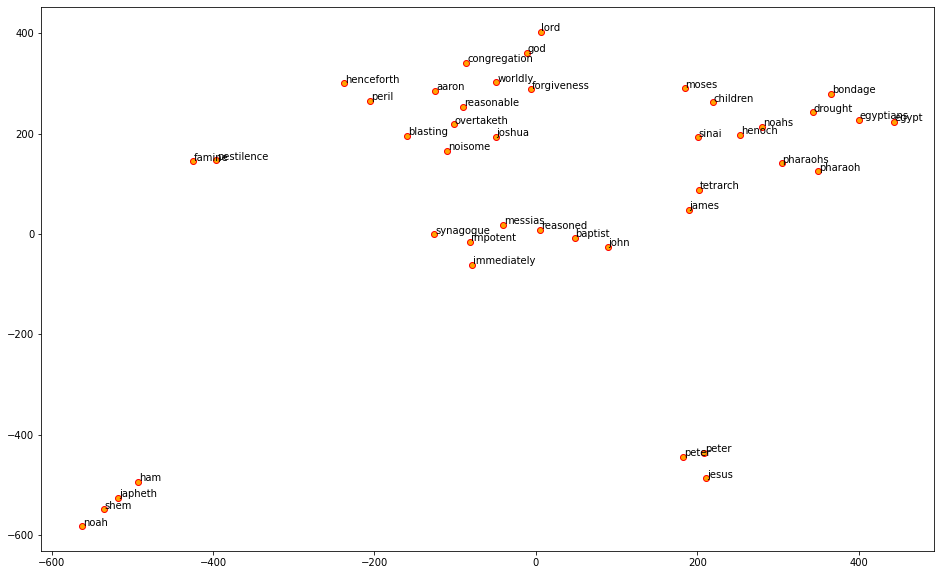

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = sum([[k] + v for k, v in similar_words.items()], [])                                                # extract word labels, assign to words
wvs = w2v_model.wv[words]                                                                                   # save word vectors for each word

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)                                     # apply TSNE to reduce dimensionality to 2
np.set_printoptions(suppress=True)                                                                          
T = tsne.fit_transform(wvs)                                                                                 # fit TSNE to word vectors
labels = words                                                                                              # assign words to labels

plt.figure(figsize=(16,10))                                                                                 # set figuresize
plt.scatter(T[:,0], T[:,1], c='orange', edgecolors='r')                                                     # plot the 2 dimension word vectors using scatterplot 
for label, x, y in zip(labels, T[:,0], T[:,1]):                                                             # apply word labels to data points
    plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')

> **What words clustered together? Are any of the clusterings sensible?**

> #### **C) Applying Word2Vec Features to Document Clustering Task**

> **Let's bring in our toy corpus from Part 1 and apply the gensim word2vec model to produce word embeddings for our new vocab set.**

In [ ]:
corpus = ['The sky is blue 12 and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast, and beans.",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick'
]

labels = ['weather', 'weather', 'animal', 'food', 'food', 'animal', 'weather', 'animal']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category':labels})

normalize_corpus = np.vectorize(normalize_document)  
norm_corpus = normalize_corpus(corpus)

In [ ]:
norm_corpus = [remove_punc(i) for i in norm_corpus]
norm_corpus

['sky blue beautiful  ',
 'love blue beautiful sky',
 'quick brown fox jumps lazy dog  ',
 'kings breakfast sausages ham bacon eggs toast beans  ',
 'love green eggs ham sausages bacon',
 'brown fox quick blue dog lazy',
 'sky blue sky beautiful today',
 'dog lazy brown fox quick']

In [ ]:
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]                                             # tokenize corpus

feature_size = 10                                                                                                   # set word2vec parameters
window_context = 10
min_word_count = 1
sample = 1e-3

In [ ]:
w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, window=window_context, min_count=min_word_count, sample=sample, iter=100) # fit word2vec to corpus

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


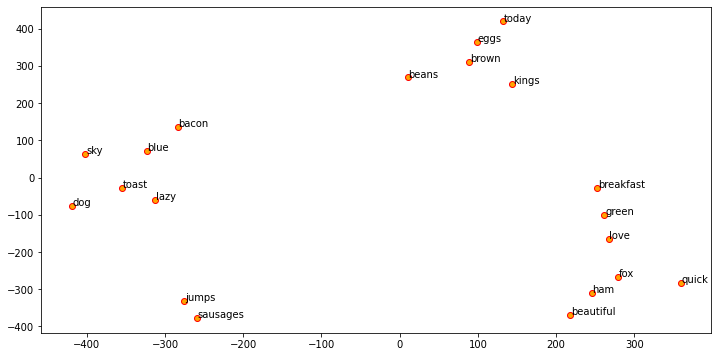

In [ ]:
from sklearn.manifold import TSNE
words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words
plt.figure(figsize=(12,6))
plt.scatter(T[:,0], T[:,1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:,0], T[:,1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')                                          # produce 2 dimensional scatterplot of word embeddings



**Which if any clusters of words make sense, semantically? Which do not?**

**Now we need to create two functions to create average word vectors across all documents so that each word has an average vector value; then we will create a average word vectorizer, so that each document has an average vector across all words in each document...**

In [ ]:
w2v_model.wv['sky']                                             # produce the weights for one word, "sky"

array([ 0.03142487, -0.02623807,  0.04057728,  0.0303534 , -0.00462514,
        0.01968556, -0.01655265,  0.02726672,  0.00124269, -0.04227021],
      dtype=float32)

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
  feature_vector = np.zeros((num_features,), dtype='float64')
  nwords= 0.

  for word in words:
    if word in vocabulary:
      nwords = nwords + 1.
      feature_vector = np.add(feature_vector, model[word])
  if nwords:
    feature_vector = np.divide(feature_vector, nwords)
  return feature_vector                                                                                                       # return average word vector


def average_word_vectorizer(corpus, model, num_features):
  vocabulary = set(model.wv.index2word)
  features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]     # return averge vector for each document in corpus
  return np.array(features)


w2v_feature_array = average_word_vectorizer(corpus = tokenized_corpus, model=w2v_model, num_features = feature_size)          # create array of document vectors
pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,0,1,2,3,4,5,6,7,8,9
0,0.000778,-0.019157,0.011116,0.014205,0.013862,0.004670,-0.025071,0.019890,0.014676,-0.013037
1,-0.009925,-0.009850,0.006837,0.017192,0.003799,-0.005535,-0.021570,0.008432,0.006246,-0.002858
2,0.019120,-0.017131,-0.010629,-0.013366,-0.002883,-0.009847,-0.007844,-0.018982,0.016667,-0.006150
3,-0.002872,-0.016373,0.011336,-0.014718,0.015384,0.011542,-0.005656,-0.004192,-0.009505,-0.015273
4,0.001710,-0.007994,0.003900,-0.005563,-0.006618,-0.002372,-0.017166,-0.011674,-0.017651,0.007205
5,0.007777,-0.014513,-0.007415,0.000116,0.006153,-0.003643,-0.012213,-0.018052,0.021424,-0.019363
6,0.015364,-0.013355,0.022952,0.004909,0.007577,0.014082,-0.022396,0.007976,0.011104,-0.023457
7,0.015822,-0.011796,-0.012713,-0.008459,0.004675,-0.008009,-0.009197,-0.020829,0.016602,-0.014148


**Why are there 8 rows? Why are there 10 columns and not the size of our vocab?**

We set our feature size to 10, so instead of having a feature for each vocab word, we have 10 averaged embedding values that represent the "meaning" of each document...

**Now let's use our document embeddings and perform a clustering analysis to examine how the documents are grouped. We will use `AffinityPropagation` from `sklearn` to produce our clusters; then we'll append the cluster label to our corpus dataframe.**

In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_

cluster_labels = pd.DataFrame(cluster_labels, columns=['Cluster Label'])
pd.concat([corpus_df, cluster_labels], axis=1)                  

,Document,Category,Cluster Label
0,The sky is blue 12 and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animal,2
3,"A king's breakfast has sausages, ham, bacon, e...",food,1
4,"I love green eggs, ham, sausages and bacon!",food,1
5,The brown fox is quick and the blue dog is lazy!,animal,2
6,The sky is very blue and the sky is very beaut...,weather,0
7,The dog is lazy but the brown fox is quick,animal,2


**Do the cluster labels match up with the number/assignment of categories we completed last time?**

**Finally, let's plot our document vectors to see where each of them fall within their clusters. We'll also utilize coloring based on cluster to make it a bit easier to read. We can reduce our document vectors down to 2 dimensions using a principal component analysis and scatterplot.**

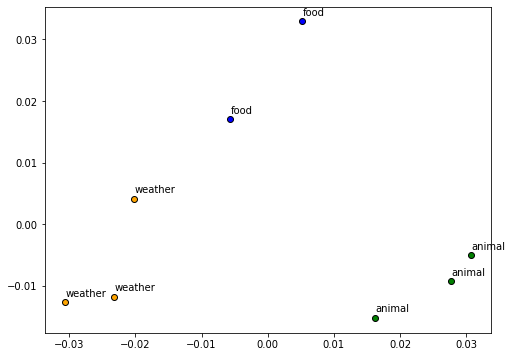

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)                                       # set parameters of PCA with 2 principle components
pcs = pca.fit_transform(w2v_feature_array)                                      # fit PCA to vector feature array to reduce dimensions
labels = ap.labels_                                                             # set cluster numbers to labels
categories = list(corpus_df['Category'])                                        # set corpus_df categories to categories
plt.figure(figsize=(8,6))                                                       # set figuresize

for i in range(len(labels)):
  label = labels[i]
  color = 'orange' if label == 0 else 'blue' if label == 1 else 'green' 
  annotation_label = categories[i]
  x, y = pcs[i]
  plt.scatter(x, y, c=color, edgecolors='k')                                    # produce scatterplot of 2-dimensional document vectors, colored and labeled by category
  plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0,0), textcoords = 'offset points')

## **4) GloVe** Word Embeddings

**Word2Vec is one option for pretrained word embeddings, but GloVe serves as an alternative model that oftentimes has better results with easier implementation. Here we will apply GloVe Features from `spacy` for the same Machine Learning Task**

> #### **A) Apply Pretrained Word-Embeddings to Toy Corpus Vocab**

In [ ]:
!pip install spacy

try: 
  spacy.load('en_core_web_lg')
except:
  !python -m spacy download en_core_web_lg                # 300 dimensional pretrained glove embeddings

In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')                        # load pretrained glove embedding model 

In [ ]:
total_vectors = len(nlp.vocab.vectors)                    # find the length of the total number of vectors applied to the vocab
print('Total Word Vectors:', total_vectors)

Total Word Vectors: 514157


In [ ]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))        # produce vocab list from norm_corpus
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])                                      # apply word vectors to vocab from norm_corpus
pd.DataFrame(word_glove_vectors, index=unique_words)                                                            # produce df of glove vectors, indexed by words

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
breakfast,-0.68660,-1.726700,-3.00130,-1.110100,1.83890,-3.076600,-0.233690,1.013300,-2.023400,3.033700,...,1.173600,-2.72720,1.57230,-2.42900,-1.527600,0.98387,-0.098775,2.95160,-1.60790,2.54120
eggs,0.94699,-3.802500,-5.22820,1.638600,4.74710,-3.459600,-2.239200,0.847490,-3.645700,3.273800,...,6.575500,1.13930,-2.46300,-7.98480,-7.093400,-2.87130,3.126500,3.40870,-4.73420,-0.91956
bacon,0.22776,-3.051600,0.26025,0.641570,2.04230,-3.136500,0.128790,0.181220,-1.535200,0.290250,...,3.504000,-1.27140,4.07630,-5.66470,0.247550,1.58200,3.224800,3.00600,2.78730,2.65260
blue,-4.31020,2.570600,-3.47220,2.520500,-1.11040,-5.101400,-1.481200,4.655900,0.383650,2.477200,...,-5.250500,4.20530,2.92490,-0.93310,0.890710,6.85240,0.075678,1.07370,-2.96000,-0.42209
quick,2.63220,2.707800,-1.19830,2.149000,3.34010,-2.768000,0.285130,0.959040,-3.211000,0.978550,...,1.742100,-0.82167,2.79760,0.21357,1.293800,0.10757,0.832680,-0.80778,-1.53100,-0.28953
sausages,-0.95324,-3.505800,-1.52990,2.149900,3.81270,-1.850400,-0.960970,1.255800,-2.262700,1.484200,...,3.824700,-0.62691,2.76300,-5.66990,-0.950370,-0.58964,2.101200,1.12920,0.98625,0.59990
jumps,2.04220,3.634600,0.49222,0.074497,1.18540,2.842600,-0.042565,5.634800,0.948340,0.402610,...,-0.538160,3.18240,1.99210,-1.43010,-0.164580,2.53300,-0.051668,1.00780,-0.29046,-1.68560
today,1.53330,1.622600,1.05520,-1.361500,0.97952,-0.828060,1.485400,2.881700,-0.354000,0.344570,...,3.243400,-1.53780,2.36610,-2.51120,-1.267200,-1.48080,-1.282500,1.41430,-2.50450,2.77440
green,-1.93390,0.314870,-4.39510,1.924700,-2.04800,-5.712100,-0.956200,2.792700,-1.307100,3.660400,...,-2.795100,0.43909,2.74080,-2.18080,-0.936220,1.71610,4.210300,-0.44140,-3.99350,-0.57955
lazy,-1.58880,0.733160,1.07460,-2.452100,-0.42517,3.334400,-0.179420,-1.092400,-0.093904,0.058663,...,1.125300,-2.35530,3.93600,-3.37510,-0.999340,1.26390,-2.106800,3.07430,-4.42900,3.89380


> #### **B) Use TSNE to visualize the glove embeddings in a lower-dimensional scatter plot.**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


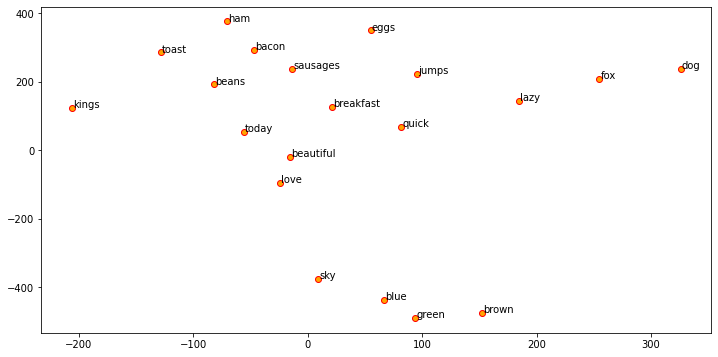

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12,6))
plt.scatter(T[:,0], T[:,1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:,1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')

**How does this scatteplot compare to that produced from word2vec embeddings?**

> #### **C) Use Kmeans clustering to cluster documents based on word embeddings**

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters = 3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_

cluster_labels = pd.DataFrame(cluster_labels, columns=['Cluster Label'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,Cluster Label
0,The sky is blue 12 and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animal,2
3,"A king's breakfast has sausages, ham, bacon, e...",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animal,2
6,The sky is very blue and the sky is very beaut...,weather,1
7,The dog is lazy but the brown fox is quick,animal,2


> #### **D) Use PCA to Produce Scatterplot of Document Clusters**

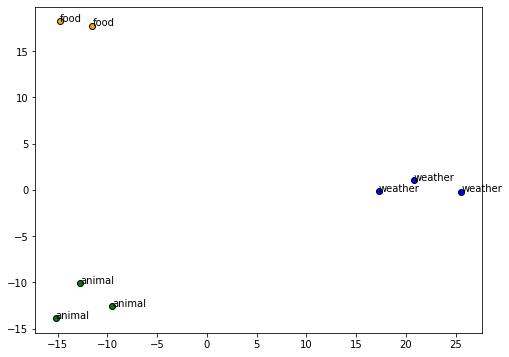

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(doc_glove_vectors)
labels = km.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8,6))

for i in range(len(labels)):
  label = labels[i]
  color = 'orange' if label == 0 else 'blue' if label == 1 else 'green' 
  annotation_label = categories[i]
  x, y = pcs[i]
  plt.scatter(x, y, c=color, edgecolors='k')
  plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0,0), textcoords = 'offset points')

**How are the document embeddings different based on GloVe as compared to Word2Vec, based on this two dimensional representation of the document clusters?**